<a href="https://colab.research.google.com/github/Bruno-Messias/FoodVision/blob/main/FoodVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Getting setup

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    # assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 4036 (delta 1069), reused 1087 (delta 998), pack-reused 2812
Receiving objects: 100% (4036/4036), 650.87 MiB | 41.96 MiB/s, done.
Resolving deltas: 100% (2362/2362), done.
Updating files: 100% (248/248), done.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get model

In [29]:
def create_model(num_classes:int=3,
                 seed:int=42):
    """Creates an feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module):  feature extractor model.
        transforms (torchvision.transforms): image transforms.
    """
    # 1. Setup pretrained model
    weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT

    # 2. Get EffNetB2 transforms
    transforms = weights.transforms()

    # 3. Setup pretrained model
    model = torchvision.models.efficientnet_v2_s(weights=weights).to(device) # could also use weights="DEFAULT" .to(device)

    # 4. Freeze the base layers in the model (this will freeze all layers to begin with)
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=1280,
                        out_features=num_classes, # same number of output units as our number of classes
                        bias=True))

    return model, transforms

In [30]:
model, transforms = create_model(num_classes=101,
                                 seed=42)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 147MB/s]


In [7]:
# # Print a summary using torchinfo (uncomment for actual output)
# summary(model=model,
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

# 2. Get Data

In [31]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    transforms,
])

In [32]:
print(f"Training transforms:\n{food101_train_transforms}\n")
print(f"Testing transforms:\n{transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

Testing transforms:
ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [33]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=transforms, # perform normal EffNetB2 transforms on test data
                             download=True)

In [34]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

# 2. Creating an  feature extractor

## 2.2 Creating DataLoaders

In [35]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [36]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

In [37]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=NUM_WORKERS)

## 2.3 Training model

In [38]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# model_compiled = torch.compile(model, backend="aot_eager")

# torch._dynamo.reset()
# model_compiled = torch.compile(model)

# Set seeds for reproducibility and train the model
set_seeds()
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.5516 | train_acc: 0.3148 | test_loss: 2.6651 | test_acc: 0.5007
Epoch: 2 | train_loss: 2.7502 | train_acc: 0.4741 | test_loss: 2.3738 | test_acc: 0.5561
Epoch: 3 | train_loss: 2.5417 | train_acc: 0.5162 | test_loss: 2.2590 | test_acc: 0.5787
Epoch: 4 | train_loss: 2.4365 | train_acc: 0.5413 | test_loss: 2.2052 | test_acc: 0.5951
Epoch: 5 | train_loss: 2.3608 | train_acc: 0.5635 | test_loss: 2.1840 | test_acc: 0.5991
Epoch: 6 | train_loss: 2.3180 | train_acc: 0.5752 | test_loss: 2.1791 | test_acc: 0.6018
Epoch: 7 | train_loss: 2.2860 | train_acc: 0.5823 | test_loss: 2.1509 | test_acc: 0.6088
Epoch: 8 | train_loss: 2.2678 | train_acc: 0.5850 | test_loss: 2.1514 | test_acc: 0.6078
Epoch: 9 | train_loss: 2.2342 | train_acc: 0.5960 | test_loss: 2.1292 | test_acc: 0.6151
Epoch: 10 | train_loss: 2.2257 | train_acc: 0.5932 | test_loss: 2.1417 | test_acc: 0.6100


## 2.4 Inspecting loss curves


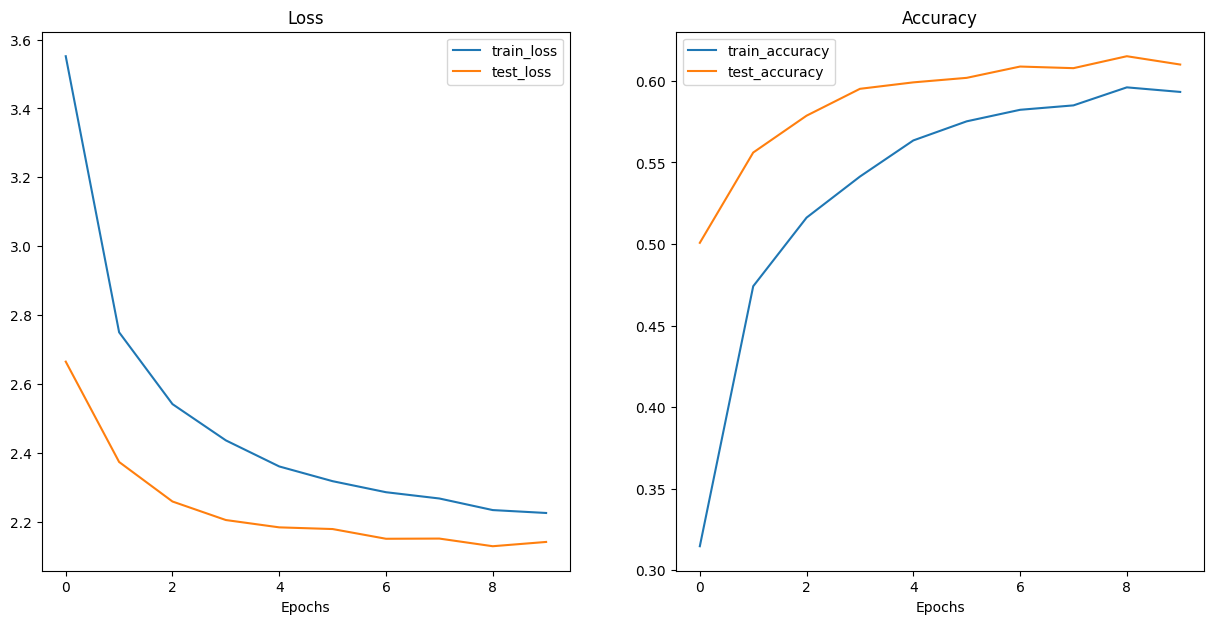

In [39]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 2.5 Saving EffNetB2 feature extractor

In [40]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=model,
                 target_dir="models",
                 model_name="model.pth")

[INFO] Saving model to: models/model.pth


## 2.6 Checking the size of EffNetB2 feature extractor

In [41]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_model_size = Path("models/model.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained feature extractor model size: {pretrained_model_size} MB")

Pretrained feature extractor model size: 78 MB


## 2.7 Collecting EffNetB2 feature extractor stats

In [42]:
# Count number of parameters in EffNetB2
model_total_params = sum(torch.numel(param) for param in model.parameters())
model_total_params

20306869

In [43]:
# Create a dictionary with EffNetB2 statistics
stats = {"test_loss": results["test_loss"][-1],
          "test_acc": results["test_acc"][-1],
          "number_of_parameters": model_total_params,
          "model_size (MB)": pretrained_model_size}
stats

{'test_loss': 2.141662242291849,
 'test_acc': 0.6099987828627069,
 'number_of_parameters': 20306869,
 'model_size (MB)': 78}

# 3. Turning our FoodVision Big model into a deployable app

In [45]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

## 3.1 Downloading an example image and moving it to the examples directory

In [47]:
# Move trained model to FoodVision Big demo folder (will error if model is already moved)
# !mv models/model.pth demos/foodvision

mv: cannot stat 'models/model.pth': No such file or directory


## 3.2 Saving Food101 class names to file (class_names.txt)

In [48]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/foodvision/class_names.txt


## 3.3 Turning our FoodVision Big model into a Python script (model.py)

In [49]:
%%writefile demos/foodvision/model.py
import torch
import torchvision

from torch import nn

def create_model(num_classes:int=3,
                 seed:int=42):
    """Creates an feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module):  feature extractor model.
        transforms (torchvision.transforms): image transforms.
    """
    # 1. Setup pretrained model
    weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT

    # 2. Get EffNetB2 transforms
    transforms = weights.transforms()

    # 3. Setup pretrained model
    model = torchvision.models.efficientnet_v2_s(weights=weights).to(device) # could also use weights="DEFAULT" .to(device)

    # 4. Freeze the base layers in the model (this will freeze all layers to begin with)
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=1280,
                        out_features=num_classes, # same number of output units as our number of classes
                        bias=True))

    return model, transforms

Writing demos/foodvision/model.py


## 3.4 Turning our FoodVision Big Gradio app into a Python script (app.py)

In [50]:
%%writefile demos/foodvision/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create model
model, transforms = create_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
model.load_state_dict(
    torch.load(
        f="model.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    model.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(model(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision"
description = "An Efficient Net V2 s feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created as an study in image classification"

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/foodvision/app.py


## 3.5 Creating a requirements file for FoodVision Big (requirements.txt)

In [54]:
%%writefile demos/foodvision/requirements.txt
torch==2.1.0
torchvision==0.16.0
gradio==3.1.4

Writing demos/foodvision/requirements.txt


## 3.6 Downloading our FoodVision Big app files

In [55]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision && zip -r ../foodvision.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/hamburger.jpg (deflated 1%)
  adding: model.pth (deflated 7%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 6%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
# Zip foodvision_big folder but exclude certain files
!cd going_modular/ && zip -r ../going_modular.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

try:
    from google.colab import files
    files.download("going_modular.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: going_modular/ (stored 0%)
  adding: going_modular/README.md (deflated 50%)
  adding: going_modular/engine.py (deflated 74%)
  adding: going_modular/train.py (deflated 57%)
  adding: going_modular/data_setup.py (deflated 66%)
  adding: going_modular/model_builder.py (deflated 67%)
  adding: going_modular/predictions.py (deflated 62%)
  adding: going_modular/utils.py (deflated 57%)
  adding: models/ (stored 0%)
  adding: models/05_going_modular_script_mode_tinyvgg_model.pth (deflated 12%)
  adding: models/05_going_modular_cell_mode_tinyvgg_model.pth (deflated 12%)
  adding: README.md (deflated 61%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>